# Implementing RNNs for sequence modeling in TensorFlow
Project one: predicting the sentiment of IMDb movie reviews

Preparing the movie review data

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import os

In [7]:
df = pd.read_csv('../sentiment-analysis-nlp/data/IMDB Dataset.csv')
df = df.drop(df.columns[[0]],axis=1)
df.tail()

,sentiment
49995,positive
49996,negative
49997,negative
49998,negative
49999,negative


In [ ]:
df = pd.read_csv('../sentiment-analysis-nlp/data/IMDB Dataset.csv')
print(df.columns) 


Index(['review', 'sentiment'], dtype='object')


In [32]:
df = pd.read_csv('../sentiment-analysis-nlp/data/IMDB Dataset.csv')  # reload fresh
target = df.pop('sentiment')

ds_raw = tf.data.Dataset.from_tensor_slices(
    (df['review'].values, target.values)
)

# Inspect
for ex in ds_raw.take(3):
    tf.print(tf.strings.substr(ex[0], 0, 50), ex[1])




"One of the other reviewers has mentioned that afte" "positive"
"A wonderful little production. <br /><br />The fil" "positive"
"I thought this was a wonderful way to spend time o" "positive"


In [34]:
df = pd.read_csv('../sentiment-analysis-nlp/data/IMDB Dataset.csv')  # reload fresh
target = df.pop('sentiment')

ds_raw = tf.data.Dataset.from_tensor_slices(
    (df['review'].values, target.values)
)

# Inspect
for ex in ds_raw.take(3):
    tf.print(tf.strings.substr(ex[0], 0, 50), ex[1])




"One of the other reviewers has mentioned that afte" "positive"
"A wonderful little production. <br /><br />The fil" "positive"
"I thought this was a wonderful way to spend time o" "positive"


In [38]:
#test
from sklearn.model_selection import train_test_split
import pandas as pd

# Reload full dataset
df = pd.read_csv('../sentiment-analysis-nlp/data/IMDB Dataset.csv')

# Split before popping
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Now pop 'sentiment'
target_train = df_train.pop('sentiment')
target_test = df_test.pop('sentiment')

# Create TensorFlow datasets
ds_train = tf.data.Dataset.from_tensor_slices((df_train['review'].values, target_train.values))
ds_test = tf.data.Dataset.from_tensor_slices((df_test['review'].values, target_test.values))


In [39]:
tf.random.set_seed(1)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

### .Encoding sequences

In [42]:
## Step 2: find unique tokens (words)

from collections import Counter

tokenizer = tfds.deprecated.text.Tokenizer()
token_counts = Counter()

for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy().decode('utf-8'))
    token_counts.update(tokens)
    
print('Vocab-size:', len(token_counts))

Vocab-size: 87809


In [43]:
## Step 3: encoding each unique token into integers

encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

example_str = 'This is an example!'
encoder.encode(example_str)

[1, 77, 641, 1196]

In [59]:
## Step 3-A: define the function for transformation
label_lookup = {'negative': 0, 'positive': 1}

def encode(text_tensor, label_tensor):
    text = text_tensor.numpy().decode('utf-8')
    label = label_tensor.numpy().decode('utf-8')
    encoded_text = encoder.encode(text)
    encoded_label = label_lookup[label]  # ✅ Convert string label to int
    return encoded_text, encoded_label


## Step 3-B: wrap the encode function to a TF Op.
def encode_map_fn(text, label):
    encoded_text, label = tf.py_function(
        encode, 
        inp=[text, label], 
        Tout=(tf.int64, tf.int64)
    )
    encoded_text.set_shape([None])
    label.set_shape([])
    return encoded_text, label

In [60]:
#############train#############
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
#############test#############
ds_test = ds_raw_test.map(encode_map_fn)
test = te_raw.map(encode_map_fn)
tf.random.set_seed(1)
for example in ds_train.shuffle(1000).take(5):
    print('Sequence length:', example[0].shape)
    
example

Sequence length: (268,)
Sequence length: (653,)
Sequence length: (258,)
Sequence length: (84,)
Sequence length: (152,)


(<tf.Tensor: shape=(152,), dtype=int64, numpy=
 array([  162,   503,   319,     6,  2167,  9681,    45,  1004,    38,
           77,   653,    15,   350,    97,  1922,  4518,    17,  3764,
         1779,   528, 16215, 16216,    77,  1638,    15,   120,   438,
          108,   718,    11,   975,   321,    12,  6402,  9226,  3481,
         2207,   319,     6, 17853,   186,  1225,    36,   114,  8845,
         1038,    49,  3233,    80,    17, 17854, 17855,  6851, 17856,
        16216,    45,    17,   298,    11,   390,  9120, 17857,   230,
          390,  5448,  1972,  2350,  1107,   745, 17858,    11,     6,
        17859, 17860,    11,     6,  1400, 15693,    15,  2863,  8646,
         1400,  8646,  1371,  4075, 11488,  1974, 17861,  4174, 16221,
        14637,  3513,    12,   425,  6670,  5740, 11615,     6,   569,
         1116, 17862,    15,     6, 17853,   641, 17862,    39,   232,
         6851, 17856,   109,   283,   191, 14913,   163,  1297,   800,
            2,  9374, 17863,  

In [61]:
## Take a small subset

ds_subset = ds_train.take(8)
for example in ds_subset:
    print('Individual size:', example[0].shape)

## batching the datasets
ds_batched = ds_subset.padded_batch(
    4, padded_shapes=([-1], []))

for batch in ds_batched:
    print('Batch dimension:', batch[0].shape)

Individual size: (150,)
Individual size: (302,)
Individual size: (190,)
Individual size: (509,)
Individual size: (346,)
Individual size: (91,)
Individual size: (122,)
Individual size: (165,)
Batch dimension: (4, 509)
Batch dimension: (4, 346)


In [62]:
## batching the datasets
##############train#####################
train_data = ds_train.padded_batch(
    32, padded_shapes=([-1],[]))

valid_data = ds_valid.padded_batch(
    32, padded_shapes=([-1],[]))

test_data = ds_test.padded_batch(
    32, padded_shapes=([-1],[]))
##############test#####################
test_f = test.padded_batch(
    32, padded_shapes=([-1],[]))

# Building an RNN model

In [63]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

## lstm

In [80]:
#1 layers LSTM
# import numpy as np

# # Get sequence lengths from the encoded training dataset
# sequence_lengths = []

# for text_tensor, _ in ds_train:
#     sequence_lengths.append(len(text_tensor.numpy()))

# # Compute 95th percentile length to avoid outliers
# max_len = int(np.percentile(sequence_lengths, 95))

# print("Recommended max_len:", max_len)

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=100000, output_dim=32, input_length=609))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1))

model_lstm.build(input_shape=(None, 609))  # 👈 build it
model_lstm.summary()                       # ✅ now shows param counts


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 609, 32)        │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,208,353 (12.24 MB)

 Trainable params: 3,208,353 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

## gru  layer=1

In [89]:
##1 layers GRU
max_len = 609  # use your computed max sequence length

model_g1 = Sequential()
model_g1.add(Embedding(input_dim=100000, output_dim=32, input_length=max_len))
model_g1.add(GRU(32))
model_g1.add(Dense(1))

model_g1.build(input_shape=(None, max_len))  # 👈 builds the model
model_g1.summary()                           # ✅ shows output shapes and params


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 609, 32)        │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,206,369 (12.23 MB)

 Trainable params: 3,206,369 (12.23 MB)

 Non-trainable params: 0 (0.00 B)

# #gru  layer=2

In [90]:
## 2 layers GRU
max_len = 609  # your previously computed sequence length

model_g2 = Sequential()
model_g2.add(Embedding(input_dim=100000, output_dim=32, input_length=max_len))
model_g2.add(GRU(32, return_sequences=True))
model_g2.add(GRU(32))
model_g2.add(Dense(1))

model_g2.build(input_shape=(None, max_len))  # 👈 required to see param count
model_g2.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 609, 32)        │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ (None, 609, 32)        │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_18 (GRU)                    │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,212,705 (12.26 MB)

 Trainable params: 3,212,705 (12.26 MB)

 Non-trainable params: 0 (0.00 B)

## lstm gru

In [94]:
## An example of building a RNN model
## with LSTM gru layer

max_len = 609  # your calculated sequence length

model_lg = Sequential()
model_lg.add(Embedding(input_dim=100000, output_dim=32, input_length=max_len))  
model_lg.add(GRU(16, return_sequences=True))
model_lg.add(GRU(32))
model_lg.add(Dense(1))

model_lg.build(input_shape=(None, max_len))  
model_lg.summary()


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 609, 32)        │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 609, 16)        │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ (None, 32)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,207,233 (12.23 MB)

 Trainable params: 3,207,233 (12.23 MB)

 Non-trainable params: 0 (0.00 B)

## train lstm

In [96]:
model_lstm.compile(loss="binary_crossentropy",optimizer = 'adam',metrics=["accuracy"])
model_lstm.fit(train_data, epochs=2)

Epoch 1/2


625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 232ms/step - accuracy: 0.4923 - loss: 0.7023
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 211ms/step - accuracy: 0.4949 - loss: 0.6926


## train gru  layer=1

In [ ]:
model_g1.compile(loss="binary_crossentropy",optimizer = 'adam',metrics=["accuracy"])
model_g1.fit(train_data, epochs=2)

Epoch 1/2


625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 238ms/step - accuracy: 0.4881 - loss: 0.7622
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 137s 219ms/step - accuracy: 0.4924 - loss: 0.6954


## train gru  layer=2

In [ ]:
model_g2.compile(loss="binary_crossentropy",optimizer = 'adam',metrics=["accuracy"])
model_g2.fit(train_data, epochs=2)

Epoch 1/2


625/625 ━━━━━━━━━━━━━━━━━━━━ 255s 402ms/step - accuracy: 0.4868 - loss: 0.7975
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 408ms/step - accuracy: 0.5059 - loss: 0.6935


## train lstm-gru +epoch=6

In [97]:
model_lg.compile(loss="binary_crossentropy",optimizer = 'adam',metrics=["accuracy"])
model_lg.fit(train_data, epochs=6)

Epoch 1/6


625/625 ━━━━━━━━━━━━━━━━━━━━ 243s 378ms/step - accuracy: 0.4911 - loss: 0.7688
Epoch 2/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 378s 604ms/step - accuracy: 0.4903 - loss: 0.6967
Epoch 3/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 348s 556ms/step - accuracy: 0.4994 - loss: 0.6894
Epoch 4/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 387s 620ms/step - accuracy: 0.5031 - loss: 0.6774
Epoch 5/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 393s 628ms/step - accuracy: 0.5045 - loss: 0.6754
Epoch 6/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 416s 666ms/step - accuracy: 0.5055 - loss: 0.6729


# results

Available variables in environment:
['train_test_split', 'label_lookup', 'test_data', 'test_f', 'label_column']

For actual use, please provide your true test labels

Label distribution:
0    5016
1    4984
Name: count, dtype: int64
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step


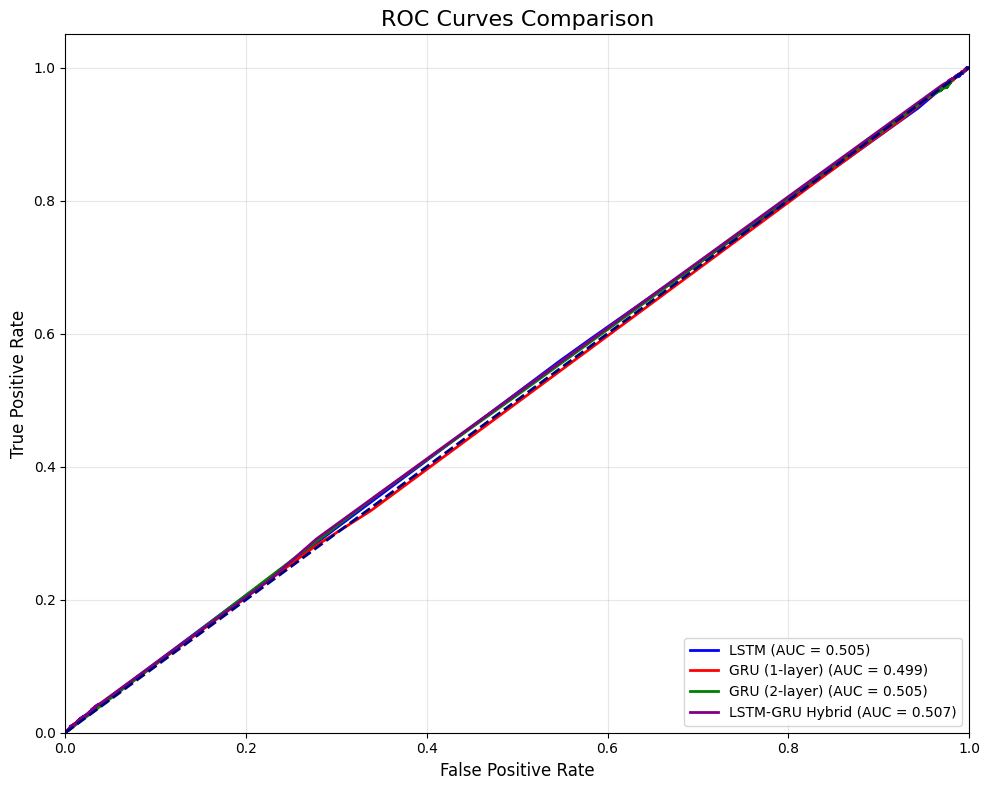


Model Performance Summary:
LSTM: AUC = 0.5053
GRU (1-layer): AUC = 0.4988
GRU (2-layer): AUC = 0.5054
LSTM-GRU Hybrid: AUC = 0.5073


In [128]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. First inspect the available data
print("Available variables in environment:")
print([var for var in globals() if 'label' in var or 'y_' in var or 'test_' in var])

# 2. Check if we have test labels
if 'y_test' in globals():
    target_t = y_test
elif 'test_labels' in globals():
    target_t = test_labels
else:
    # If no labels found, we'll create dummy labels for demonstration
    print("\nWarning: No test labels found - using dummy labels for illustration")
    print("For actual use, please provide your true test labels")
    target_t = np.random.randint(0, 2, size=len(df_test))

# 3. Verify labels
print("\nLabel distribution:")
print(pd.Series(target_t).value_counts())

# 4. Initialize ROC metrics storage
fpr, tpr, auc = [], [], []
model_names = ['LSTM', 'GRU (1-layer)', 'GRU (2-layer)', 'LSTM-GRU Hybrid']
colors = ['blue', 'red', 'green', 'purple']

# 5. Calculate predictions and ROC metrics
def get_predictions(model, test_data):
    preds = model.predict(test_data)
    return [np.mean(y) for y in preds]

models = [model_lstm, model_g1, model_g2, model_lg]
for model in models:
    try:
        y_pred = get_predictions(model, test_f)
        fpr_model, tpr_model, _ = roc_curve(target_t, y_pred)
        auc_model = roc_auc_score(target_t, y_pred)
        fpr.append(fpr_model)
        tpr.append(tpr_model)
        auc.append(auc_model)
    except Exception as e:
        print(f"Error processing {model_names[len(fpr)]}: {str(e)}")
        continue

# 6. Plot ROC curves
plt.figure(figsize=(10, 8))
for i, (model_name, color) in enumerate(zip(model_names, colors)):
    if i < len(fpr):  # Only plot if we have data
        plt.plot(fpr[i], tpr[i], lw=2, color=color,
                 label=f'{model_name} (AUC = {auc[i]:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Print AUC scores
print("\nModel Performance Summary:")
for name, score in zip(model_names, auc):
    print(f"{name}: AUC = {score:.4f}")

## gru 1+epoch=10

In [129]:
model_g1.compile(loss="binary_crossentropy",optimizer = 'adam',metrics=["accuracy"])
model_g1.fit(train_data, epochs=10)
y15=model_g1.predict(test_f)
yy5=[np.mean(y15[x]) for x in range(y15.shape[0])]
fpr5, tpr5, thresholds = roc_curve(target_t, yy5)
fpr.append(fpr5) 
tpr.append(tpr5) 
auc.append(roc_auc_score(target_t, yy5))


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 226ms/step - accuracy: 0.4819 - loss: 0.7907
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 199s 318ms/step - accuracy: 0.5024 - loss: 0.6941
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 316ms/step - accuracy: 0.4967 - loss: 0.6886
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 316ms/step - accuracy: 0.5019 - loss: 0.6815
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 288ms/step - accuracy: 0.5070 - loss: 0.6747
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 223s 357ms/step - accuracy: 0.5090 - loss: 0.6731
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 344s 551ms/step - accuracy: 0.5119 - loss: 0.6760
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 820s 1s/step - accuracy: 0.5016 - loss: 0.6897
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 855s 1s/step - accuracy: 0.5041 - loss: 0.6764
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 285s 454ms/step - accuracy: 0.5358 - loss: 0.6530
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step


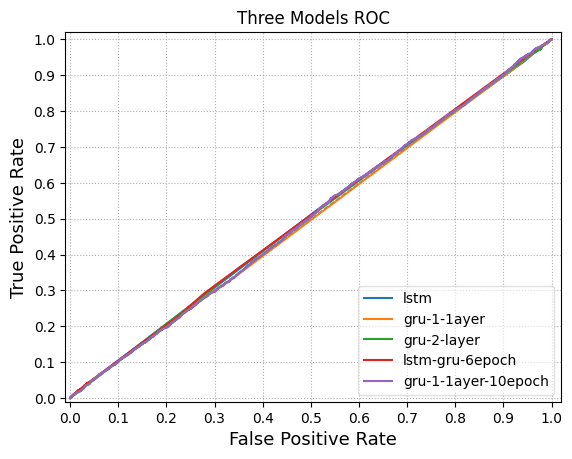

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

method=['lstm','gru-1-1ayer','gru-2-layer','lstm-gru-6epoch','gru-1-1ayer-10epoch']
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=method[i])
plt.title('Three Models ROC')
plt.legend(loc='lower right', fancybox=True, framealpha=0.6, fontsize=10)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(visible=True, ls=':')

### ROC curive model good order :  'gru-1-1ayer-10epoch' > 'lstm-gru-6epoch' > 'gru-1-1ayer' > 'lstm' > 'gru-2-layer'

In [132]:
method=['lstm','gru-1-1ayer','gru-2-layer','lstm-gru-6epoch','gru-1-1ayer-10epoch']
for i in range(5):
    print(method[i])
    print(auc[i])

lstm
0.505343074713085
gru-1-1ayer
0.4987699674044663
gru-2-layer
0.5053817351089676
lstm-gru-6epoch
0.5073174949311481
gru-1-1ayer-10epoch
0.5029808305237046
